Methane Leak Detection System
This repository contains a Python script for detecting methane leaks using sensor data.

Description
The code in this repository accomplishes the following tasks:

Data Loading: Loads data from a CSV containing sensor readings.
Data Extraction: Extracts relevant columns from the dataset.
Mathematical Model: Uses a custom function to model a certain physical process based on the sensor readings.
Parameter Optimization: Fits the mathematical model to the data to obtain optimal parameters.
Prediction: Predicts methane values based on the optimized model.
Drift Calculation: Calculates drift in the sensor readings, especially focusing on areas where 'Target PPM' is 0.
Drift Correction: Corrects the predicted methane values based on the calculated drift.
Residual Calculation: Calculates residuals to understand the prediction errors.
Leak Detection: Uses the corrected predictions to detect potential methane leaks.
Visualization: Plots the detected leaks, predictions, and drift to provide a visual understanding of the system's findings.
Usage
Ensure you have the required libraries installed. Mainly, you'd need:

pandas
numpy
matplotlib
scipy
Run the script: python script_name.py (Replace script_name.py with the appropriate script's name).

Code Breakdown
Here's a brief overview of what each segment in the code does:

Data Loading: The data from the CSV file containing sensor readings is loaded into a pandas DataFrame.

Data Extraction: The relevant columns like Resistance, Ratio, Relative Humidity, Temperature, and Target PPM are extracted for analysis.

Mathematical Model: A function named funct3 is used as a mathematical model for the readings, taking into account various parameters.

Parameter Optimization: The script employs the curve_fit function from scipy to determine the optimal parameters for the model.

Prediction: Methane values are predicted using the funct3 model and the optimized parameters.

Drift Calculation & Correction: The script calculates a drift in the sensor readings and then corrects for it.

Residual Calculation: Differences between the corrected and predicted values are determined.

Leak Detection: The script uses a threshold to detect potential methane leaks.

Visualization: Detected leaks, the predicted values, and drift are plotted for visual inspection.

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

0.9682930871234233 -0.3601235337422842 -8.84990439470642 0.3947805968686195 -251.22855834970915 18.373402040466768


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_5178/3057645767.py:10: RuntimeWarning: invalid value encountered in power
  return a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_5178/3057645767.py:10: RuntimeWarning: overflow encountered in power
  return a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f


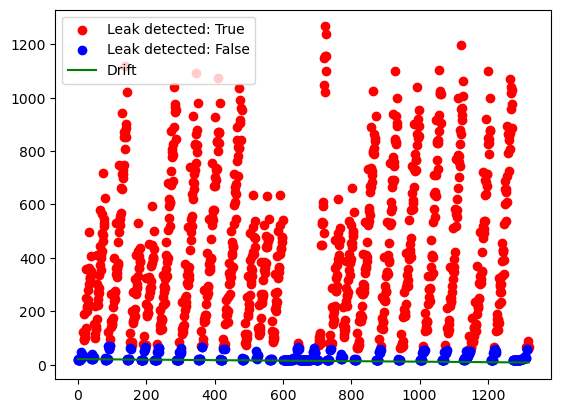

In [2]:

df = pd.read_csv("/Users/benfunk/DataspellProjects/MethaneDataScience/Output/With low Data .csv")
xDataResistance = df.loc[:, 'Resistance']
xDataRatio = df.loc[:, 'Ratio']
xDataRH = df.loc[:, 'RelativeHumidity']
xDataTemp = df.loc[:, 'Temperature']
yDataTargetPPM = df.loc[:, 'Target PPM']

def funct3(X, a, b, c, d, e, f):
    R, H, T = X
    return a**((((-1*R)/(H**b))*c)+(-1*H*d)+e)+f

p0 = 1, 1, 1, 1, 1,1
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance, xDataRH, xDataTemp), yDataTargetPPM, p0, maxfev=1000000)

print(*popt)
# Create 'predicted' column
df['predicted'] = funct3((xDataResistance, xDataRH, xDataTemp), *popt)

# Create a new DataFrame where 'Target PPM' is 0
# Create a new DataFrame where 'Target PPM' is 0
df2 = df[df['Target PPM'] == 0]

# Fit a line to the predicted data using only the subset of data where 'Target PPM' is 0
slope, intercept = np.polyfit(np.arange(len(df2)), df2['predicted'], 1)

# Calculate the drift for the entire DataFrame
df['drift'] = np.arange(len(df))*slope + intercept

# Correct for drift
df['corrected'] = df['predicted'] - df['drift']

# Detect methane leaks
df['residual'] = df['corrected'] - df['predicted']

df['leak_detected'] = (df['predicted'] > df['drift']+50)

# Plotting
time_indices = np.arange(len(df))
for leak_detected, color in zip([True, False], ['red', 'blue']):
    plt.scatter(time_indices[df['leak_detected'] == leak_detected],
                df['predicted'][df['leak_detected'] == leak_detected],
                color=color,
                label=f"Leak detected: {leak_detected}")

# Plot the drift
plt.plot(time_indices, df['drift'], color='green', label='Drift')

plt.legend()
plt.show()